# TASK for the Senior NGS Bioinformatician position: Ibai Irastorza

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pybedtools as pb
import umi_tools
import pysam

In [46]:
bam_dir = "data"
results_dir = "results"
samples = ["sample1", "sample2", "sample3"] 
# then, index it: samtools index -M sample1_chr.bam sample2_chr.bam sample3_chr.bam
#reference_genome = "annotations/hg19.fa"  
reference_genome = "annotations/human_g1k_v37.fasta"  
reference_gtf = "annotations/hg19.refGene.gtf"
#reference_genome = "annotations/Homo_sapiens.GRCh37.dna.toplevel.fa.gz"  
#reference_gtf = "annotations/Homo_sapiens.GRCh37.87.gtf"

## Quality check and visualization of the bam files

In [47]:
for i in range(3):  
    bam_path = f"{bam_dir}/{samples[i]}.bam"
    stats_path = f"{results_dir}/{samples[i]}.stats"
    plots_path = f"{results_dir}/{samples[i]}"
    !samtools stats {bam_path} > {stats_path}
    #!plot-bamstats -p {plots_path} {stats_path}
# flagstats

In [48]:
! java -jar /home/ibai/Downloads/picard/build/libs/picard.jar ValidateSamFile I=data/sample1.bam MODE=VERBOSE

INFO	2025-05-30 00:14:49	ValidateSamFile	

********** NOTE: Picard's command line syntax is changing.
**********
********** For more information, please see:
********** 
https://github.com/broadinstitute/picard/wiki/Command-Line-Syntax-Transition-For-Users-(Pre-Transition)
**********
********** The command line looks like this in the new syntax:
**********
**********    ValidateSamFile -I data/sample1.bam -MODE VERBOSE
**********


00:14:49.799 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/ibai/Downloads/picard/build/libs/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Fri May 30 00:14:49 CEST 2025] ValidateSamFile INPUT=data/sample1.bam MODE=VERBOSE    MAX_OUTPUT=100 IGNORE_WARNINGS=false VALIDATE_INDEX=true INDEX_VALIDATION_STRINGENCY=EXHAUSTIVE IS_BISULFITE_SEQUENCED=false MAX_OPEN_TEMP_FILES=8000 SKIP_MATE_VALIDATION=false VERBOSITY=INFO QUIET=false VALIDATION_STRINGENCY=STRICT COMPRESSION_LEVEL=5 MAX_RECORDS_IN_RAM=500000 CREATE_INDEX=false 

#### Many flags and annotations are not properly set. Fix them.

In [49]:
for i in range(3):  
    bam_path = f"{bam_dir}/{samples[i]}.bam"
    print ("sample {}".format(i+1))
    bam_path_fixed = f"{bam_dir}/{samples[i]}_fixed.bam"
    stats_path = f"{results_dir}/{samples[i]}_fixed.stats"
    plots_path = f"{results_dir}/{samples[i]}"
    aux_path = f"{bam_dir}/aux.bam"
    aux2_path = f"{bam_dir}/aux2.bam"
    
    !samtools sort -n -o {aux_path} {bam_path} 
    !samtools fixmate -m {aux_path} {aux2_path}
    !samtools sort -o {aux_path} {aux2_path}
    #!samtools stats {aux_path} > {stats_path}
    !samtools view -b -f 1 {aux_path} > {aux2_path} # remove unpaired (they are very few (11K out of 1.5M for sample1) 
    # remove totally sofclipped reads (150S) and others that do not contain at least MIDN
    cmd = f"samtools view -h {aux2_path} | awk 'BEGIN{{OFS=\"\\t\"}} /^@/ {{print; next}} $6 ~ /[MIDN]/ {{print}}' | samtools view -bo {aux_path}"
    !{cmd}
    # remove also CIGARs with more than 1 N
    cmd = f"samtools view -h {aux_path}  | awk 'BEGIN{{OFS=\"\\t\"}} /^@/ {{print; next}} $6 !~ /.*N.*N/ {{print}}' | samtools view -bo {aux2_path}"    
    !{cmd}
    cmd = f"samtools view -h {aux2_path} | " \
      "awk 'BEGIN{OFS=\"\\t\"} /^@/ {print; next} " \
      "{seen[$1]++; reads[NR]=$0; names[NR]=$1} " \
      "END {for(i=1;i<=NR;i++) if(seen[names[i]]==2) print reads[i]}' | " \
      f"samtools view -b -o {aux_path}"
    !{cmd}
    !samtools calmd -b {aux_path} {reference_genome} > {aux2_path}
    #!samtools view -b -q 30 {aux2_path} > {bam_path_fixed} # even though I only get 0 1 3 or 255
    ! java -jar /home/ibai/Downloads/picard/build/libs/picard.jar AddOrReplaceReadGroups  \
        -I {aux2_path} \
        -O {aux_path}  \
        -RGID sample1  \
        -RGSM sample1  \
        -RGLB sample1  \
        -RGPU sample1  \
        -RGPL ILLUMINA
    ! java -jar /home/ibai/Downloads/picard/build/libs/picard.jar MarkDuplicates \
          I={aux_path} \
          O={bam_path_fixed} \
          M=results/dup_metrics_{i}.txt \
          VALIDATION_STRINGENCY=SILENT
    !samtools stats {bam_path_fixed} > {stats_path}
        

sample 1
00:15:49.946 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/ibai/Downloads/picard/build/libs/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Fri May 30 00:15:49 CEST 2025] AddOrReplaceReadGroups --INPUT data/aux2.bam --OUTPUT data/aux.bam --RGID sample1 --RGLB sample1 --RGPL ILLUMINA --RGPU sample1 --RGSM sample1 --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 5 --MAX_RECORDS_IN_RAM 500000 --CREATE_INDEX false --CREATE_MD5_FILE false --help false --version false --showHidden false --USE_JDK_DEFLATER false --USE_JDK_INFLATER false
[Fri May 30 00:15:50 CEST 2025] Executing as ibai@ibai-PC on Linux 6.8.0-60-generic amd64; OpenJDK 64-Bit Server VM 21.0.7+6-Ubuntu-0ubuntu124.04; Deflater: Intel; Inflater: Intel; Provider GCS is available; Picard version: Version:3.4.0-1-ge81c6b019-SNAPSHOT
INFO	2025-05-30 00:15:50	AddOrReplaceReadGroups	Created read-group ID=sample1 PL=ILLUMINA LB=sample1 SM=sample1

INFO	2025

In [50]:
# I need to index it again
for i in range(3):  
    bam_path_fixed = f"{bam_dir}/{samples[i]}_fixed.bam"
    !samtools index {bam_path_fixed}

In [51]:
# Check again consistency
! java -jar /home/ibai/Downloads/picard/build/libs/picard.jar ValidateSamFile I=data/sample1_fixed.bam R=annotations/human_g1k_v37.fasta MODE=VERBOSE
! java -jar /home/ibai/Downloads/picard/build/libs/picard.jar ValidateSamFile I=data/sample2_fixed.bam R=annotations/human_g1k_v37.fasta MODE=VERBOSE
! java -jar /home/ibai/Downloads/picard/build/libs/picard.jar ValidateSamFile I=data/sample3_fixed.bam R=annotations/human_g1k_v37.fasta MODE=VERBOSE

INFO	2025-05-30 00:19:25	ValidateSamFile	

********** NOTE: Picard's command line syntax is changing.
**********
********** For more information, please see:
********** 
https://github.com/broadinstitute/picard/wiki/Command-Line-Syntax-Transition-For-Users-(Pre-Transition)
**********
********** The command line looks like this in the new syntax:
**********
**********    ValidateSamFile -I data/sample1_fixed.bam -R annotations/human_g1k_v37.fasta -MODE VERBOSE
**********


00:19:25.463 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/ibai/Downloads/picard/build/libs/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Fri May 30 00:19:25 CEST 2025] ValidateSamFile INPUT=data/sample1_fixed.bam MODE=VERBOSE REFERENCE_SEQUENCE=annotations/human_g1k_v37.fasta    MAX_OUTPUT=100 IGNORE_WARNINGS=false VALIDATE_INDEX=true INDEX_VALIDATION_STRINGENCY=EXHAUSTIVE IS_BISULFITE_SEQUENCED=false MAX_OPEN_TEMP_FILES=8000 SKIP_MATE_VALIDATION=false VERBOSITY=INFO QUIET=fa

In [52]:
suffix = "_fixed"

## Deduplicate the reads with UMI tools

In [53]:
#Dediplucates bams with umi_tools
for i in range(3):  
    bam_path = f"{bam_dir}/{samples[i]}{suffix}.bam"
    stats_path = f"{results_dir}/{samples[i]}{suffix}.stats"
    dedup_bam_path = f"{bam_dir}/{samples[i]}{suffix}_dedup.bam"
    dedup_stats_path = f"{results_dir}/{samples[i]}{suffix}_dedup.stats"
    !samtools index {bam_path}
    !umi_tools dedup -I {bam_path} --paired --extract-umi-method=tag --umi-tag=mb -S {dedup_bam_path}
    !samtools stats {dedup_bam_path} > {dedup_stats_path}
    !samtools index {dedup_bam_path}
suffix += "_dedup" 

# UMI-tools version: 1.1.6
# output generated by dedup -I data/sample1_fixed.bam --paired --extract-umi-method=tag --umi-tag=mb -S data/sample1_fixed_dedup.bam
# job started at Fri May 30 00:19:53 2025 on ibai-PC -- 2d4fd824-31b6-431c-9e80-093fde34344a
# pid: 57050, system: Linux 6.8.0-60-generic #63-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 15 19:04:15 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filter_umi                              : None
# gene_tag                                : None
# gene_transcript_map                     : None
# get_umi_method                          : tag
# ignore_tlen                             : False
# ign

## Calculate gene coverage

In [54]:

for i in range(3):  
    bam_path = f"{bam_dir}/{samples[i]}{suffix}.bam"
    results_path = f"{results_dir}/{samples[i]}_gene_counts.txt"
    !/home/ibai/Downloads/subread-2.1.1-Linux-x86_64/bin/featureCounts -a {reference_gtf} -o {results_path} -p --countReadPairs -T 4 {bam_path}


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.1.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                                                                            ||
||                           sample1_fixed_dedup.bam                          ||
||                                                                            ||
||             Output file : sample1_gene_counts.txt             

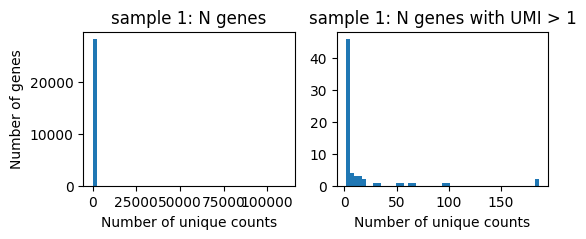

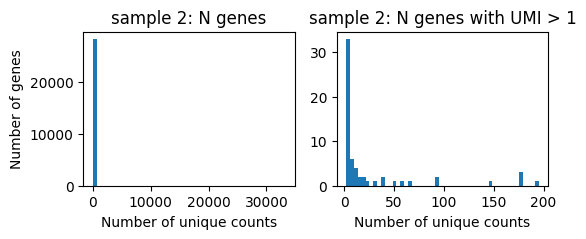

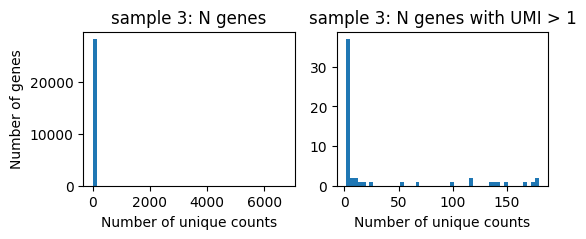

In [55]:
df_list = []
for i in range(3):  
    results_path = f"{results_dir}/{samples[i]}_gene_counts.txt"
    df = pd.read_csv(results_path, sep="\t", comment="#")
    count_column = df.columns[-1]
    df.rename(columns={count_column: "UMI_counts"}, inplace=True)
    df_list.append(df)
    df2 = df.query("UMI_counts > 1 and UMI_counts <= 200")
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,2))
    ax1.hist(df["UMI_counts"].values,bins=50)
    ax2.hist(df2["UMI_counts"].values,bins=50)
    ax1.set_title("sample {}: N genes".format(i+1))
    ax1.set_xlabel("Number of unique counts")
    ax1.set_ylabel("Number of genes")
    ax2.set_title("sample {}: N genes with UMI > 1".format(i+1))
    ax2.set_xlabel("Number of unique counts")
    #fig.savefig("plots/{}.pdf".format(name))




In [56]:
# Maybe genes contain low number of counts. I will set the cutoff in 50, to get few candidates. IF they are not enough I can modify this.

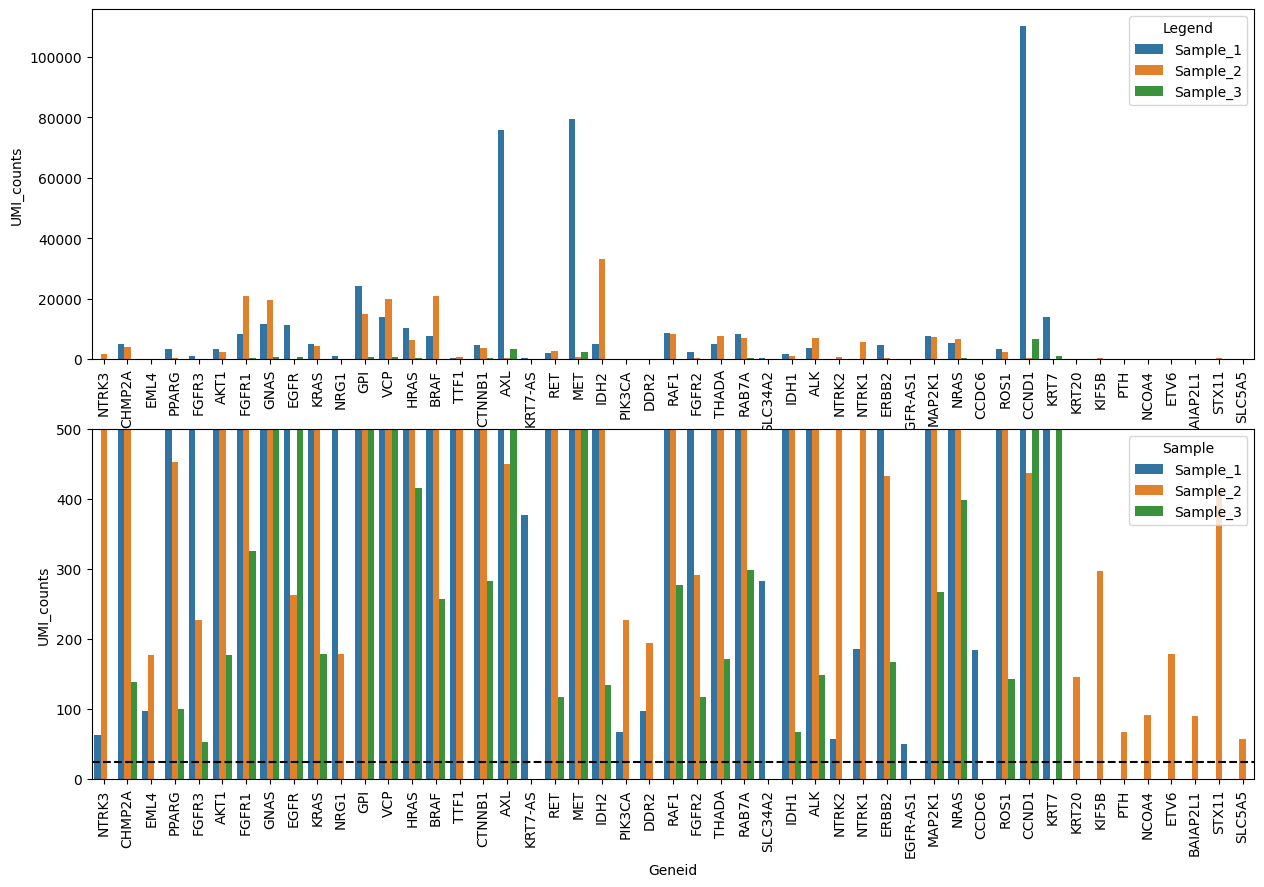

In [57]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15, 10))
combined_df = pd.concat([df.assign(Sample="Sample_{}".format(i+1)) for i, df in enumerate(df_list)])
combined_df = combined_df.query("UMI_counts >= 50")    
sns.barplot(data=combined_df, x="Geneid", y="UMI_counts",ax=ax1,hue="Sample")
sns.barplot(data=combined_df, x="Geneid", y="UMI_counts",ax=ax2,hue="Sample")
ax1.legend(title="Legend")
ax2.set_ylim(0,500)
ax1.tick_params(axis='x', labelrotation=90)
ax2.tick_params(axis='x', labelrotation=90)
ax2.axhline(25,color="black",linestyle="--")
plt.savefig("plots/unique_counts_in_genes.pdf")

### Get a set of housekeeping genes for quality control

In [58]:
hk_genes = pd.read_csv("annotations/HSIAO_HOUSEKEEPING_GENES.v2024.1.Hs.grp",skiprows=2,header=None, delim_whitespace=True)
# List of HK genes. https://www.gsea-msigdb.org/gsea/msigdb/cards/HSIAO_HOUSEKEEPING_GENES
targeted_genes = list(set(combined_df.Geneid.values.tolist()))
hk_genes_list = hk_genes[0].tolist()
intersect = list(set(targeted_genes) & set(hk_genes_list))
print (intersect)

['CTNNB1', 'GNAS']


/tmp/ipykernel_6902/511541511.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  hk_genes = pd.read_csv("annotations/HSIAO_HOUSEKEEPING_GENES.v2024.1.Hs.grp",skiprows=2,header=None, delim_whitespace=True)


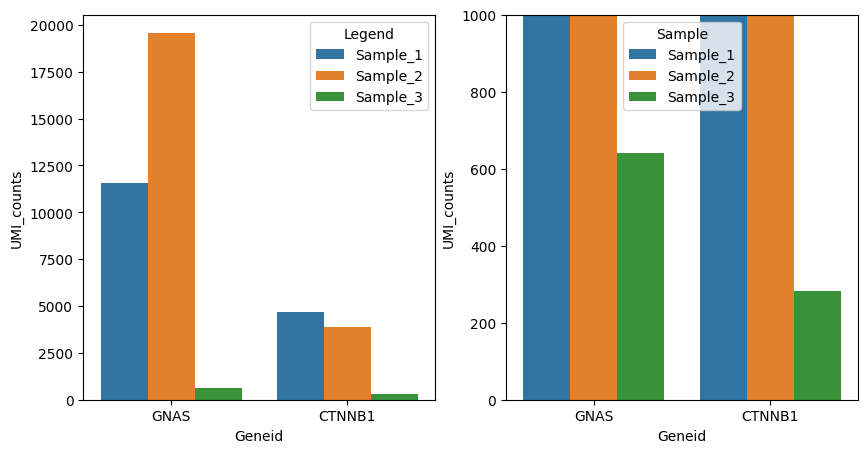

In [59]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 5))
combined_hk_df = combined_df[combined_df["Geneid"].isin(intersect)]
sns.barplot(data=combined_hk_df, x="Geneid", y="UMI_counts",ax=ax1,hue="Sample")
ax1.legend(title="Legend")
sns.barplot(data=combined_hk_df, x="Geneid", y="UMI_counts",ax=ax2,hue="Sample")
ax1.legend(title="Legend")
ax2.set_ylim(0,1000)
plt.savefig("plots/unique_counts_in_HK_genes.pdf")

Number of unique UMIs in sample 1: 65295


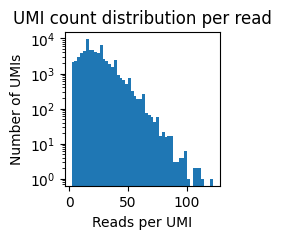

Number of unique UMIs in sample 2: 62133


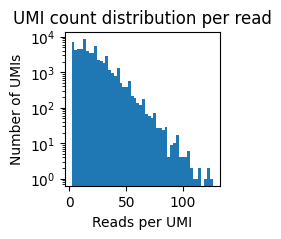

Number of unique UMIs in sample 3: 18826


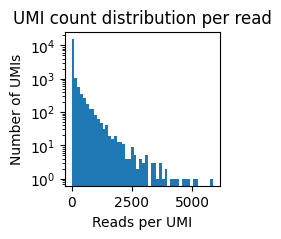

In [60]:
from collections import Counter

for i in range(3):  
    bamfile = "data/sample{}.bam".format(i+1)
    umi_counts = Counter()
    
    with pysam.AlignmentFile(bamfile, "rb") as bam:
        for read in bam.fetch(until_eof=True):
            if read.has_tag("mb"):   
                umi = read.get_tag("mb")
                umi_counts[umi] += 1
                
    num_unique_umis = len(umi_counts)
    print(f"Number of unique UMIs in sample {i+1}: {num_unique_umis}")
    
    # Plot UMI frequency distribution (how many reads per UMI)
    counts = list(umi_counts.values())
    fig,ax = plt.subplots(figsize=(2,2))
    plt.hist(counts, bins=50, log=True)
    plt.xlabel("Reads per UMI")
    plt.ylabel("Number of UMIs")
    plt.title("UMI count distribution per read")
    plt.show()

Number of unique UMIs in sample 1: 65033


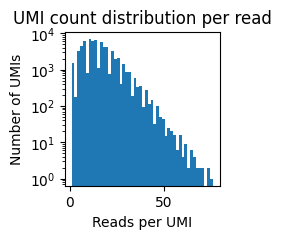

Number of unique UMIs in sample 2: 59091


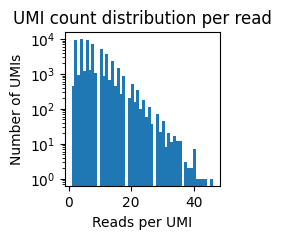

Number of unique UMIs in sample 3: 8315


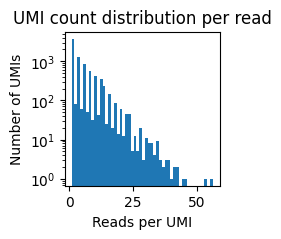

In [61]:
for i in range(3):  
    bamfile = "data/sample{}_fixed_dedup.bam".format(i+1)
    umi_counts = Counter()
    
    with pysam.AlignmentFile(bamfile, "rb") as bam:
        for read in bam.fetch(until_eof=True):
            if read.has_tag("mb"):   
                umi = read.get_tag("mb")
                umi_counts[umi] += 1
                
    num_unique_umis = len(umi_counts)
    print(f"Number of unique UMIs in sample {i+1}: {num_unique_umis}")
    
    # Plot UMI frequency distribution (how many reads per UMI)
    counts = list(umi_counts.values())
    fig,ax = plt.subplots(figsize=(2,2))
    plt.hist(counts, bins=50, log=True)
    plt.xlabel("Reads per UMI")
    plt.ylabel("Number of UMIs")
    plt.title("UMI count distribution per read")
    plt.show()

possible UMIS?

4^8=65,536

sample 1 and 2 are fine, even though at the limit, maybe having 9 or 10 bps would have helped
sample 3 looks like way lower. Maybe there was low material from the beginning?


#### Count again gene coverage to compare the raw data with the deduplicated data

In [62]:
for i in range(3):  
    bam_path = f"{bam_dir}/{samples[i]}.bam"
    results_path = f"{results_dir}/{samples[i]}_gene_counts_prededup.txt"
    !/home/ibai/Downloads/subread-2.1.1-Linux-x86_64/bin/featureCounts -a {reference_gtf} -o {results_path} -p --countReadPairs -T 4 {bam_path}




        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.1.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                                                                            ||
||                           sample1.bam                                      ||
||                                                                            ||
||             Output file : sample1_gene_counts_prededup.txt    

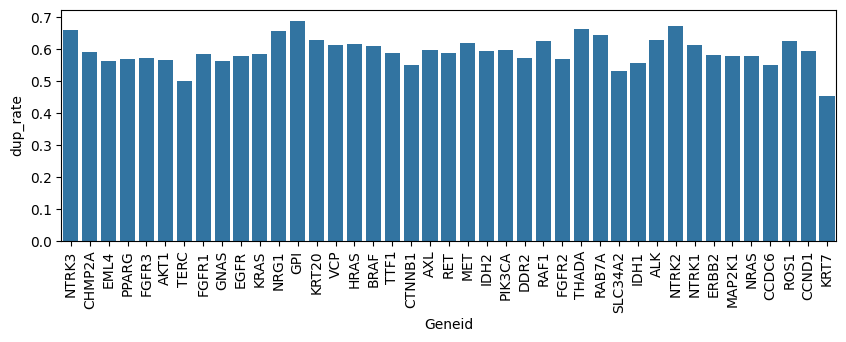

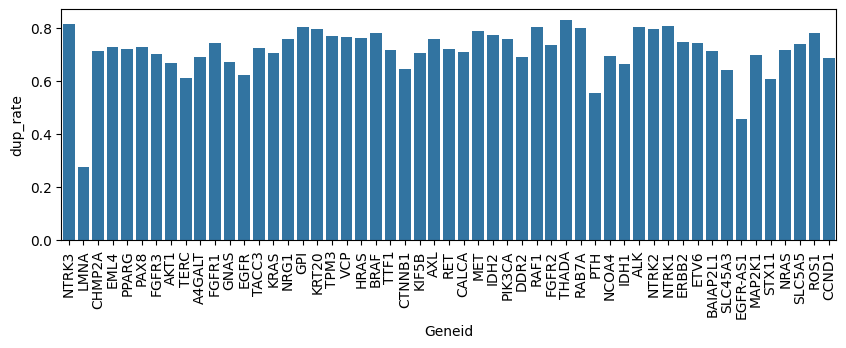

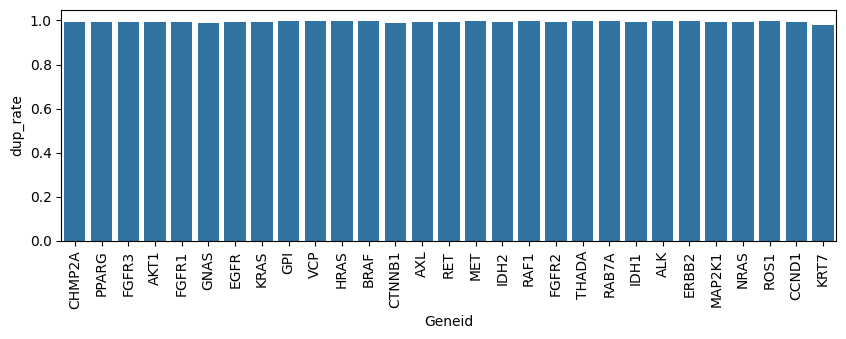

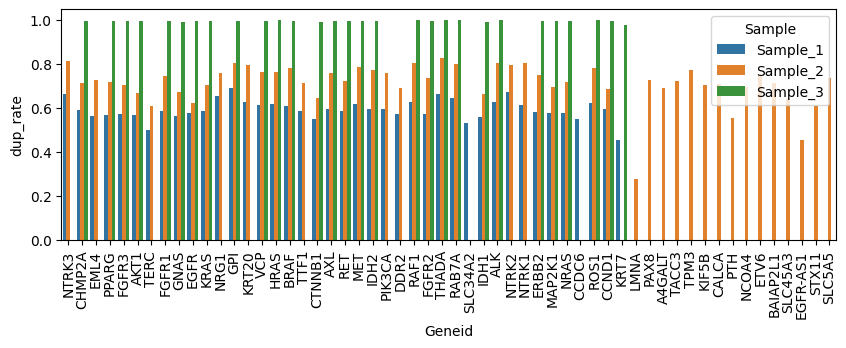

In [63]:
duplicated_dfs = []
for i in range(1,4):
    raw = pd.read_csv("results/sample{}_chr_filtered_gene_counts_prededup.txt".format(i), sep="\t", comment="#")
    count_column = raw.columns[-1]
    raw.rename(columns={count_column: "UMI_counts"}, inplace=True)
    
    dedup = pd.read_csv("results/sample{}_chr_filtered_gene_counts.txt".format(i), sep="\t", comment="#")
    count_column = dedup.columns[-1]
    dedup.rename(columns={count_column: "UMI_counts"}, inplace=True)
    
    merged = raw.merge(dedup, on="Geneid", suffixes=("_raw", "_dedup"))
    merged["dup_rate"] = 1 - (merged["UMI_counts_dedup"] / merged["UMI_counts_raw"])
    merged = merged.query("dup_rate >= 0.1 and UMI_counts_dedup > 25")
    duplicated_dfs.append(merged)
    fig, ax = plt.subplots(figsize=(10, 3))
    sns.barplot(data=merged, x="Geneid", y="dup_rate",ax=ax)
    plt.xticks(rotation=90)
    plt.show()
fig, ax = plt.subplots(figsize=(10, 3))
combined_df = pd.concat([df.assign(Sample="Sample_{}".format(i+1)) for i, df in enumerate(duplicated_dfs)])
sns.barplot(data=combined_df, x="Geneid", y="dup_rate",ax=ax,hue="Sample")
plt.xticks(rotation=90)
plt.show()

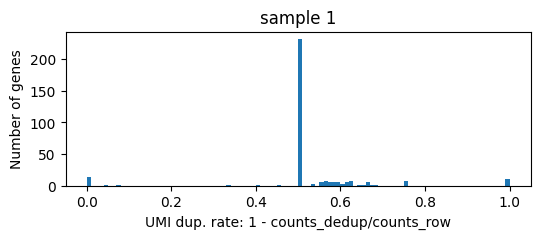

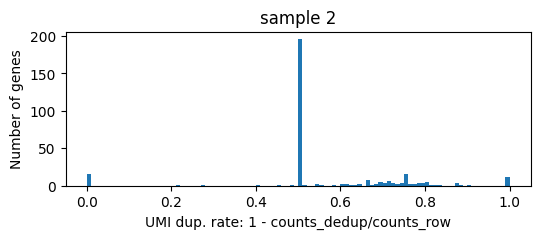

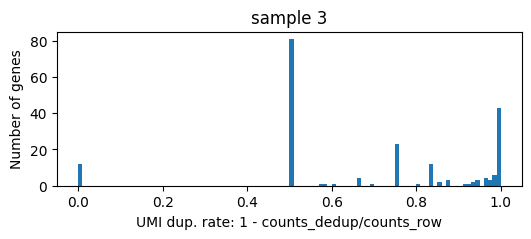

In [64]:
duplicated_dfs = []
for i in range(1,4):
    raw = pd.read_csv("results/sample{}_chr_filtered_gene_counts_prededup.txt".format(i), sep="\t", comment="#")
    count_column = raw.columns[-1]
    raw.rename(columns={count_column: "UMI_counts"}, inplace=True)
    
    dedup = pd.read_csv("results/sample{}_chr_filtered_gene_counts.txt".format(i), sep="\t", comment="#")
    count_column = dedup.columns[-1]
    dedup.rename(columns={count_column: "UMI_counts"}, inplace=True)
    
    merged = raw.merge(dedup, on="Geneid", suffixes=("_raw", "_dedup"))
    merged["dup_rate"] = 1 - (merged["UMI_counts_dedup"] / merged["UMI_counts_raw"])
    
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.hist(merged.dup_rate,bins=100)
    ax.set_ylabel("Number of genes")
    ax.set_title("sample {}".format(i))
    ax.set_xlabel("UMI dup. rate: 1 - counts_dedup/counts_row")
    plt.show()

I have 3 samples. 
Sample number 3 does not look ok. The few transcripts that pass the cutoff are targetting very few genes and also de number of duplicates in those gene is extremely high. Myabe there was low complexity or little input material?



In [65]:
# Write targeted genes for each sample in files
genes_in_samples = []

for sample in ["Sample_1","Sample_2","Sample_3"]:
    gene_list = list(set(combined_df[combined_df["Sample"] == sample].Geneid.values.tolist()))
    genes_in_samples.append(gene_list)
    with open ("results/targeted_genes_{}.txt".format(sample),"w") as stdout:
        for gene in gene_list:
            stdout.write("{}\n".format(gene))


In [66]:
final_genes_subset = []
for gene in targeted_genes:
    aux = combined_df[combined_df["Geneid"] == gene]
    samples_ = aux.Sample.values.tolist()
    if ("Sample_1" in samples_) and ("Sample_2" in samples_):
    #if ("Sample_1" in samples_) and ("Sample_2" in samples_) and ("Sample_3" in samples_):
        final_genes_subset.append(gene)
print (final_genes_subset)
print (f"{len(final_genes_subset)} genes are found in all 2 samples, out of {len(targeted_genes)}")


['EML4', 'RAB7A', 'NTRK1', 'DDR2', 'MAP2K1', 'NRAS', 'RET', 'IDH1', 'NRG1', 'NTRK3', 'ERBB2', 'THADA', 'NTRK2', 'ROS1', 'FGFR1', 'EGFR', 'PPARG', 'ALK', 'FGFR2', 'FGFR3', 'GPI', 'CCND1', 'RAF1', 'AKT1', 'PIK3CA', 'GNAS', 'BRAF', 'KRT20', 'IDH2', 'MET', 'KRAS', 'AXL', 'CTNNB1', 'TTF1', 'CHMP2A', 'HRAS', 'VCP']
37 genes are found in all 2 samples, out of 49


Sample 1:
30 oncogenes ouf of 41 total targeted genes
0 tumor suppressor ouf of 41 total targeted genes
Sample 2:
34 oncogenes ouf of 53 total targeted genes
1 tumor suppressor ouf of 53 total targeted genes
Sample 3:
23 oncogenes ouf of 29 total targeted genes
0 tumor suppressor ouf of 29 total targeted genes


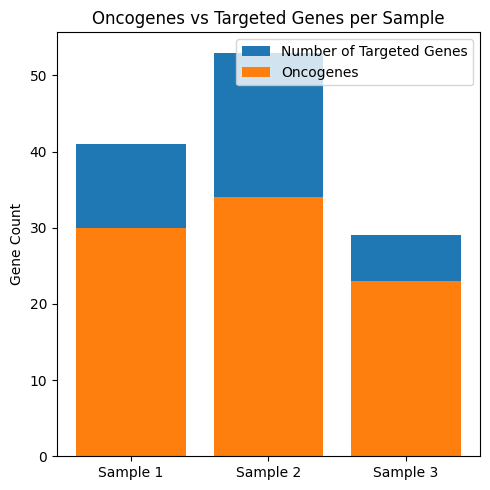

In [67]:
# compare against a cancer gene list from oncoKB
onco_df = pd.read_csv("annotations/cancerGeneList.tsv",sep="\t")
oncogenes_df = onco_df[onco_df["Is Oncogene"] == "Yes"]
aux = oncogenes_df["Gene Aliases"].dropna().values.tolist() 
flattened_list = [item.strip() for sublist in aux for item in sublist.split(',')]
oncogenes_list = flattened_list + oncogenes_df["Hugo Symbol"].values.tolist()
tumor_suppressor_genes_df = onco_df[onco_df["Is Tumor Suppressor Gene"] == "Yes"]
tumor_suppressor_genes_list = tumor_suppressor_genes_df["Gene Aliases"].dropna().values.tolist() + tumor_suppressor_genes_df["Hugo Symbol"].values.tolist()
oncogene_counts = []
targeted_gene_counts = []
for n,genes_in_sample in enumerate(genes_in_samples):
    print (f"Sample {n+1}:")
    intersect = list(set(genes_in_sample) & set(oncogenes_list))
    print (f"{len(intersect)} oncogenes ouf of {len(genes_in_sample)} total targeted genes")
    oncogene_counts.append(len(intersect))
    targeted_gene_counts.append(len(genes_in_sample))
    intersect = list(set(genes_in_sample) & set(tumor_suppressor_genes_list))
    print (f"{len(intersect)} tumor suppressor ouf of {len(genes_in_sample)} total targeted genes")

fig,ax = plt.subplots(figsize=(5, 5))
ax.bar(range(3), targeted_gene_counts, label='Number of Targeted Genes')
ax.bar(range(3), oncogene_counts, label='Oncogenes', bottom=0)

plt.xticks( range(3),["Sample 1", "Sample 2", "Sample 3"])
plt.ylabel('Gene Count')
plt.title('Oncogenes vs Targeted Genes per Sample')
plt.legend()
plt.tight_layout()
plt.show()

# get a list of these genes to later build a smaller genome for soft clip analysis
list_of_all_oncogemes = oncogenes_list+ tumor_suppressor_genes_list
with open ("annotations/onco_gene_list.txt", "w") as stdout:
    for gene in list_of_all_oncogemes:
        stdout.write(f"{gene}\n")

## Variant Calling

#### Notes:
 Download b37 data (hg19) from here: https://gist.github.com/ShujiaHuang/56fe45439afc208a3fc2e8cf85803cf8

wget -c -O human_g1k_v37.fasta.gz ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/human_g1k_v37.fasta.gz

~/Downloads/bwa/bwa index human_g1k_v37.fasta.gz

DOwnload known sites of variation files 

wget -c ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/b37/dbsnp_138.b37.vcf.gz

wget -c ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/b37/Mills_and_1000G_gold_standard.indels.b37.vcf.gz


hg19 PoN (Exomes) https://console.cloud.google.com/storage/browser/gatk-best-practices/somatic-b37?inv=1&invt=AbyjAQ&pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))

wget https://storage.googleapis.com/gatk-best-practices/somatic-b37/Mutect2-exome-panel.vcf



In [33]:
# index and get the dict for genome with samtools for gatk

!samtools faidx annotations/human_g1k_v37.fasta
! ~/Downloads/gatk-4.6.1.0/gatk CreateSequenceDictionary -R annotations/human_g1k_v37.fasta  -O annotations/human_g1k_v37.fasta.dict

Using GATK jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar CreateSequenceDictionary -R annotations/human_g1k_v37.fasta -O annotations/human_g1k_v37.fasta.dict
13:14:47.947 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
[Wed May 28 13:14:47 CEST 2025] CreateSequenceDictionary --OUTPUT annotations/human_g1k_v37.fasta.dict --REFERENCE annotations/human_g1k_v37.fasta --TRUNCATE_NAMES_AT_WHITESPACE true --NUM_SEQUENCES 2147483647 --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 2 --MAX_RECORDS_IN_RAM 500000 --CREATE_INDEX false --CREATE_MD5_FILE false --help false --v

In [68]:
# gh19.dict and index needed
#! ~/Downloads/gatk-4.6.1.0/gatk Mutect2 -R annotations/hg19.fa -I data/sample1_chr_filtered_dedup_reheaded.bam -I data/sample2_chr_filtered_dedup_reheaded.bam -I data/sample3_chr_filtered_dedup_reheaded.bam  --panel-of-normals annotations/Mutect2-exome-panel_reheaded.vcf -O results/mutect2_variants_calling.vcf

# I followed the GATK best practices on RNAseq short variant discover: https://gatk.broadinstitute.org/hc/en-us/articles/360035531192-RNAseq-short-variant-discovery-SNPs-Indels

! ~/Downloads/gatk-4.6.1.0/gatk SplitNCigarReads -R annotations/human_g1k_v37.fasta -I data/sample1_fixed_dedup.bam -O data/sample1_fixed_dedup_split.bam
! ~/Downloads/gatk-4.6.1.0/gatk SplitNCigarReads -R annotations/human_g1k_v37.fasta -I data/sample2_fixed_dedup.bam -O data/sample2_fixed_dedup_split.bam
! ~/Downloads/gatk-4.6.1.0/gatk SplitNCigarReads -R annotations/human_g1k_v37.fasta -I data/sample3_fixed_dedup.bam -O data/sample3_fixed_dedup_split.bam


Using GATK jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar SplitNCigarReads -R annotations/human_g1k_v37.fasta -I data/sample1_fixed_dedup.bam -O data/sample1_fixed_dedup_split.bam
00:21:33.737 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
SLF4J(W): Class path contains multiple SLF4J providers.
SLF4J(W): Found provider [org.apache.logging.slf4j.SLF4JServiceProvider@712e787e]
SLF4J(W): Found provider [ch.qos.logback.classic.spi.LogbackServiceProvider@53ea380b]
SLF4J(W): See https://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J(I): Actual provider is of type [org.apache.log

In [174]:
!zcat annotations/1000G_phase1.indels.b37.vcf.gz > annotations/1000G_phase1.indels.b37.vcf
!bgzip -c annotations/1000G_phase1.indels.b37.vcf > annotations/1000G_phase1.indels.b37.good.vcf.gz
!tabix -p vcf annotations/1000G_phase1.indels.b37.good.vcf.gz
!~/Downloads/gatk-4.6.1.0/gatk IndexFeatureFile -I annotations/1000G_phase1.indels.b37.good.vcf.gz


Using GATK jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar IndexFeatureFile -I annotations/1000G_phase1.indels.b37.good.vcf.gz
00:22:39.946 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
SLF4J(W): Class path contains multiple SLF4J providers.
SLF4J(W): Found provider [org.apache.logging.slf4j.SLF4JServiceProvider@4cc12db2]
SLF4J(W): Found provider [ch.qos.logback.classic.spi.LogbackServiceProvider@5ea7bc4]
SLF4J(W): See https://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J(I): Actual provider is of type [org.apache.logging.slf4j.SLF4JServiceProvider@4cc12db2]
00:22:40.397 

In [175]:
!zcat annotations/dbsnp_138.b37.vcf.gz > annotations/dbsnp_138.b37.vcf
!bgzip -c annotations/dbsnp_138.b37.vcf > annotations/dbsnp_138.b37.good.vcf.gz
!tabix -p vcf annotations/dbsnp_138.b37.good.vcf.gz
!~/Downloads/gatk-4.6.1.0/gatk IndexFeatureFile -I annotations/dbsnp_138.b37.good.vcf.gz

Using GATK jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar IndexFeatureFile -I annotations/dbsnp_138.b37.good.vcf.gz
00:37:20.884 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
SLF4J(W): Class path contains multiple SLF4J providers.
SLF4J(W): Found provider [org.apache.logging.slf4j.SLF4JServiceProvider@4cc12db2]
SLF4J(W): Found provider [ch.qos.logback.classic.spi.LogbackServiceProvider@5ea7bc4]
SLF4J(W): See https://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J(I): Actual provider is of type [org.apache.logging.slf4j.SLF4JServiceProvider@4cc12db2]
00:37:21.403 INFO  Inde

In [176]:
!zcat annotations/Mills_and_1000G_gold_standard.indels.b37.vcf.gz > annotations/Mills_and_1000G_gold_standard.indels.b37.vcf
!bgzip -c annotations/Mills_and_1000G_gold_standard.indels.b37.vcf > annotations/Mills_and_1000G_gold_standard.indels.b37.good.vcf.gz
!tabix -p vcf annotations/Mills_and_1000G_gold_standard.indels.b37.good.vcf.gz
!~/Downloads/gatk-4.6.1.0/gatk IndexFeatureFile -I annotations/Mills_and_1000G_gold_standard.indels.b37.good.vcf.gz

Using GATK jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar IndexFeatureFile -I annotations/Mills_and_1000G_gold_standard.indels.b37.good.vcf.gz
00:40:02.672 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
SLF4J(W): Class path contains multiple SLF4J providers.
SLF4J(W): Found provider [org.apache.logging.slf4j.SLF4JServiceProvider@4cc12db2]
SLF4J(W): Found provider [ch.qos.logback.classic.spi.LogbackServiceProvider@5ea7bc4]
SLF4J(W): See https://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J(I): Actual provider is of type [org.apache.logging.slf4j.SLF4JServiceProvider@4cc12d

In [69]:
# Run the baserecalibrator

suffix = "_fixed_dedup_split"
for i in range(0,3):
    bam_path = f"{bam_dir}/{samples[i]}{suffix}.bam"
    results_path = f"{results_dir}/{samples[i]}{suffix}_recal_data.table"
    ! ~/Downloads/gatk-4.6.1.0/gatk BaseRecalibrator \
        -I {bam_path} \
        -R {reference_genome} \
        --known-sites annotations/1000G_phase1.indels.b37.good.vcf.gz \
        --known-sites annotations/dbsnp_138.b37.good.vcf.gz \
        --known-sites annotations/Mills_and_1000G_gold_standard.indels.b37.good.vcf.gz \
        -O {results_path} 

# --known-sites annotations/gnomad.v4.1.sv.sites.vcf.gz \ # different genome version


Using GATK jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar BaseRecalibrator -I data/sample1_fixed_dedup_split.bam -R annotations/human_g1k_v37.fasta --known-sites annotations/1000G_phase1.indels.b37.good.vcf.gz --known-sites annotations/dbsnp_138.b37.good.vcf.gz --known-sites annotations/Mills_and_1000G_gold_standard.indels.b37.good.vcf.gz -O results/sample1_fixed_dedup_split_recal_data.table
00:22:35.798 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
SLF4J(W): Class path contains multiple SLF4J providers.
SLF4J(W): Found provider [org.apache.logging.slf4j.SLF4JServiceProvider@4f3c7808]
SLF4J(W)

In [70]:
# Apply the baserecalibrator

suffix = "_fixed_dedup_split"
for i in range(0,3):
    bam_path = f"{bam_dir}/{samples[i]}{suffix}.bam"
    results_path = f"{results_dir}/{samples[i]}{suffix}_recal_data.table"
    bam_path_recal = f"{bam_dir}/{samples[i]}{suffix}_recal.bam"
    ! ~/Downloads/gatk-4.6.1.0/gatk ApplyBQSR \
        -R {reference_genome} \
        -I {bam_path} \
        --bqsr-recal-file {results_path} \
        -O {bam_path_recal}



Using GATK jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar ApplyBQSR -R annotations/human_g1k_v37.fasta -I data/sample1_fixed_dedup_split.bam --bqsr-recal-file results/sample1_fixed_dedup_split_recal_data.table -O data/sample1_fixed_dedup_split_recal.bam
00:22:43.843 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
SLF4J(W): Class path contains multiple SLF4J providers.
SLF4J(W): Found provider [org.apache.logging.slf4j.SLF4JServiceProvider@578c3fd9]
SLF4J(W): Found provider [ch.qos.logback.classic.spi.LogbackServiceProvider@245cb8df]
SLF4J(W): See https://www.slf4j.org/codes.html#multiple_binding

In [ ]:
# index the panel
! ~/Downloads/gatk-4.6.1.0/gatk IndexFeatureFile -I annotations/Mutect2-exome-panel.vcf

In [71]:
# run Mutect2

suffix = "_fixed_dedup_split"
for i in range(0,3):
    results_path = f"{results_dir}/mutect2_variants_calling_{samples[i]}.vcf"
    bam_path_recal = f"{bam_dir}/{samples[i]}{suffix}_recal.bam"
    ! ~/Downloads/gatk-4.6.1.0/gatk Mutect2 \
        -R {reference_genome} \
        -I {bam_path_recal} \
        --panel-of-normals annotations/Mutect2-exome-panel.vcf \
        -O {results_path}



Using GATK jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar Mutect2 -R annotations/human_g1k_v37.fasta -I data/sample1_fixed_dedup_split_recal.bam --panel-of-normals annotations/Mutect2-exome-panel.vcf -O results/mutect2_variants_calling_sample1.vcf
00:23:17.087 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
SLF4J(W): Class path contains multiple SLF4J providers.
SLF4J(W): Found provider [org.apache.logging.slf4j.SLF4JServiceProvider@68aec50]
SLF4J(W): Found provider [ch.qos.logback.classic.spi.LogbackServiceProvider@6aff97d6]
SLF4J(W): See https://www.slf4j.org/codes.html#multiple_bindings for a

In [72]:
print (reference_genome)

annotations/human_g1k_v37.fasta


do some plots comparing the variant allele frequencies

In [73]:
# Function to extract necessary data for plots
def extract_vaf_from_vcf(vcf_file):
    vcf = pysam.VariantFile(vcf_file)
    records = []

    for rec in vcf:
        try:
            sample = list(rec.samples.values())[0]
            ad = sample['AD']
            dp = sample['DP']

            if ad and dp and len(ad) > 1 and dp > 0:
                vaf = ad[1] / sum(ad)
                records.append({
                    'CHROM': rec.chrom,
                    'POS': rec.pos,
                    'REF': rec.ref,
                    'ALT': rec.alts[0],
                    'DP': dp,
                    'VAF': vaf
                })
        except Exception as e:
            continue  

    return pd.DataFrame(records)

# Extract VAF data from your two VCFs


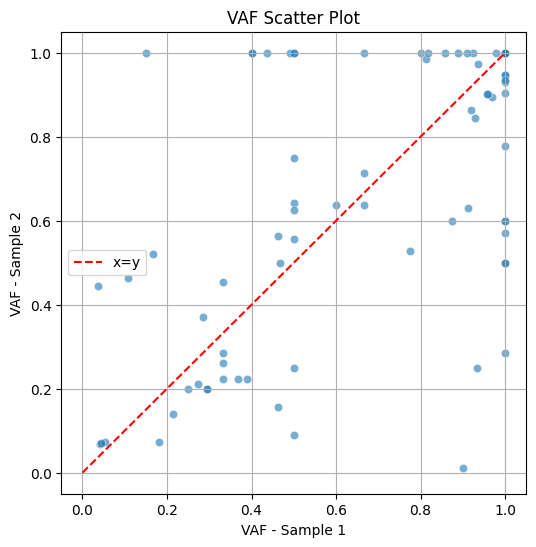

724
1008


In [74]:
df1 = extract_vaf_from_vcf(f"{results_dir}/mutect2_variants_calling_{samples[0]}.vcf")
df2 = extract_vaf_from_vcf(f"{results_dir}/mutect2_variants_calling_{samples[1]}.vcf")
merged = pd.merge(df1, df2, on=["CHROM", "POS"], suffixes=('_Sample1', '_Sample2'))
plt.figure(figsize=(6, 6))
sns.scatterplot(data=merged, x="VAF_Sample1", y="VAF_Sample2", alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', label="x=y")
plt.xlabel("VAF - Sample 1")
plt.ylabel("VAF - Sample 2")
plt.title("VAF Scatter Plot")
plt.legend()
plt.grid(True)
plt.show()
print (len(df1))
print (len(df2))

In [75]:
# Filter the variants
for i in range(0,3):
    results_path = f"{results_dir}/mutect2_variants_calling_{samples[i]}.vcf"
    results_passed_path = f"{results_dir}/mutect2_variants_calling_passed_{samples[i]}.vcf"
    ! ~/Downloads/gatk-4.6.1.0/gatk FilterMutectCalls \
        -V {results_path} \
        -R {reference_genome} \
        -O {results_passed_path}


Using GATK jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar FilterMutectCalls -V results/mutect2_variants_calling_sample1.vcf -R annotations/human_g1k_v37.fasta -O results/mutect2_variants_calling_passed_sample1.vcf
00:45:06.059 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
SLF4J(W): Class path contains multiple SLF4J providers.
SLF4J(W): Found provider [org.apache.logging.slf4j.SLF4JServiceProvider@ca7e37f]
SLF4J(W): Found provider [ch.qos.logback.classic.spi.LogbackServiceProvider@99a8de3]
SLF4J(W): See https://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J(I): Actual pro

In [76]:

# run funconator to get relevance of the somatic variants.

for i in range(0,3):
    results_passed_path = f"{results_dir}/mutect2_variants_calling_passed_{samples[i]}.vcf"
    results_passed_funconator_path = f"{results_dir}/mutect2_variants_calling_passed_funconator_{samples[i]}.vcf"
    ! ~/Downloads/gatk-4.6.1.0/gatk Funcotator \
        --variant {results_passed_path} \
        --reference {reference_genome} \
        --ref-version hg19 \
        --force-b37-to-hg19-reference-contig-conversion \
        --data-sources-path annotations/funcotator_dataSources.v1.8.hg19.20230908s \
        --output {results_passed_funconator_path} \
        --output-file-format VCF


Using GATK jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar Funcotator --variant results/mutect2_variants_calling_passed_sample1.vcf --reference annotations/human_g1k_v37.fasta --ref-version hg19 --force-b37-to-hg19-reference-contig-conversion --data-sources-path annotations/funcotator_dataSources.v1.8.hg19.20230908s --output results/mutect2_variants_calling_passed_funconator_sample1.vcf --output-file-format VCF
00:45:16.638 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/ibai/Downloads/gatk-4.6.1.0/gatk-package-4.6.1.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
SLF4J(W): Class path contains multiple SLF4J providers.
SLF4J(W): Found provider [org.apache.logging.slf4j.SLF4JServiceProvider

In [82]:
# Apply the filter of 50 UMIS to variants

for i in range (0,3):
    results_passed_funconator_path = f"{results_dir}/mutect2_variants_calling_passed_funconator_{samples[i]}.vcf"
    results_passed_funconator_gz_path = f"{results_dir}/mutect2_variants_calling_passed_funconator_{samples[i]}.vcf.gz"
    results_quality_passed_funconator_path = f"{results_dir}/mutect2_variants_calling_passed_funconator_DP_quality_{samples[i]}.vcf"
    #!bgzip {results_passed_funconator_path}
    #!tabix -p vcf {results_passed_funconator_gz_path}
    !~/Downloads/bcftools/bcftools view -e 'INFO/DP <= 50' -Ov -o {results_quality_passed_funconator_path} {results_passed_funconator_gz_path}
#for i in range (0,3):
#    results_passed_funconator_path = f"{results_dir}/mutect2_variants_calling_passed_funconator_{samples[i]}.vcf"
#    results_passed_funconator_gz_path = f"{results_dir}/mutect2_variants_calling_passed_funconator_{samples[i]}.vcf.gz"
#    results_quality_passed_funconator_path = f"{results_dir}/mutect2_variants_calling_passed_funconator_DP_quality_{samples[i]}.vcf"
#    !bgzip {results_passed_funconator_path}
#    !tabix -p vcf {results_passed_funconator_gz_path}
#    !~/Downloads/bcftools/bcftools view -e 'INFO/DP <= 50' -Ov -o {results_quality_passed_funconator_path} {results_passed_funconator_gz_path}

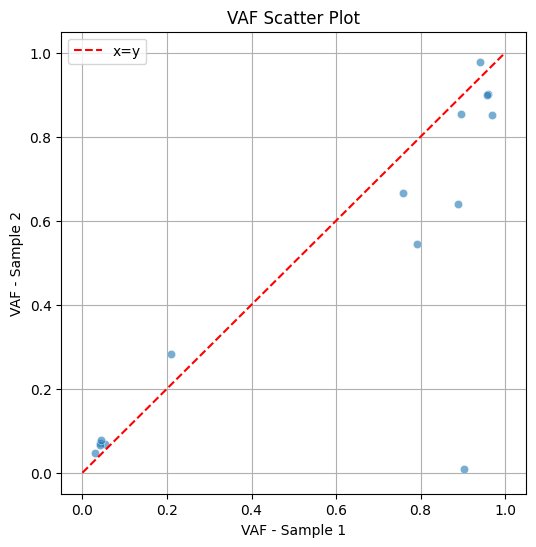

81
75


In [83]:
df1 = extract_vaf_from_vcf(f"{results_dir}/mutect2_variants_calling_passed_funconator_DP_quality_{samples[0]}.vcf")
df2 = extract_vaf_from_vcf(f"{results_dir}/mutect2_variants_calling_passed_funconator_DP_quality_{samples[1]}.vcf")
merged = pd.merge(df1, df2, on=["CHROM", "POS"], suffixes=('_Sample1', '_Sample2'))
plt.figure(figsize=(6, 6))
sns.scatterplot(data=merged, x="VAF_Sample1", y="VAF_Sample2", alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', label="x=y")
plt.xlabel("VAF - Sample 1")
plt.ylabel("VAF - Sample 2")
plt.title("VAF Scatter Plot")
plt.legend()
plt.grid(True)
plt.show()
print (len(df1))
print (len(df2))

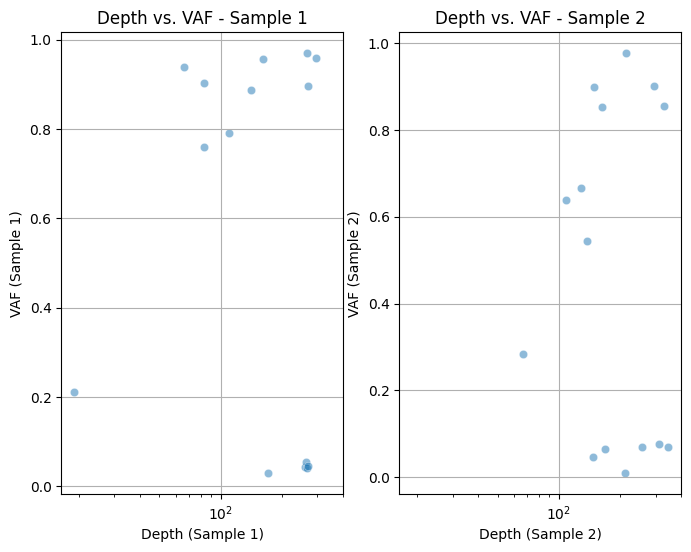

In [84]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8, 6),sharex=True)
sns.scatterplot(data=merged, x="DP_Sample1", y="VAF_Sample1", alpha=0.5, ax=ax1)
ax1.set_xlabel("Depth (Sample 1)")
ax1.set_ylabel("VAF (Sample 1)")
ax1.set_title("Depth vs. VAF - Sample 1")
ax1.set_xscale("log")
ax1.grid(True)
sns.scatterplot(data=merged, x="DP_Sample2", y="VAF_Sample2", alpha=0.5, ax=ax2)
ax2.set_xlabel("Depth (Sample 2)")
ax2.set_ylabel("VAF (Sample 2)")
ax2.set_title("Depth vs. VAF - Sample 2")
ax2.set_xscale("log")
ax2.grid(True)
plt.show()

In [85]:
import re

#funcotator_fields = "Gencode_43_hugoSymbol|Gencode_43_ncbiBuild|Gencode_43_chromosome|Gencode_43_start|Gencode_43_end|Gencode_43_variantClassification|Gencode_43_secondaryVariantClassification|Gencode_43_variantType|Gencode_43_refAllele|Gencode_43_tumorSeqAllele1|Gencode_43_tumorSeqAllele2|Gencode_43_genomeChange|Gencode_43_annotationTranscript|Gencode_43_transcriptStrand|Gencode_43_transcriptExon|Gencode_43_transcriptPos|Gencode_43_cDnaChange|Gencode_43_codonChange|Gencode_43_proteinChange|Gencode_43_gcContent|Gencode_43_referenceContext|Gencode_43_otherTranscripts|Achilles_Top_Genes|CGC_Name|CGC_GeneID|CGC_Chr|CGC_Chr_Band|CGC_Cancer_Somatic_Mut|CGC_Cancer_Germline_Mut|CGC_Tumour_Types__(Somatic_Mutations)|CGC_Tumour_Types_(Germline_Mutations)|CGC_Cancer_Syndrome|CGC_Tissue_Type|CGC_Cancer_Molecular_Genetics|CGC_Mutation_Type|CGC_Translocation_Partner|CGC_Other_Germline_Mut|CGC_Other_Syndrome/Disease|ClinVar_HGMD_ID|ClinVar_SYM|ClinVar_TYPE|ClinVar_ASSEMBLY|ClinVar_rs|ClinVar_VCF_AF_ESP|ClinVar_VCF_AF_EXAC|ClinVar_VCF_AF_TGP|ClinVar_VCF_ALLELEID|ClinVar_VCF_CLNDISDB|ClinVar_VCF_CLNDISDBINCL|ClinVar_VCF_CLNDN|ClinVar_VCF_CLNDNINCL|ClinVar_VCF_CLNHGVS|ClinVar_VCF_CLNREVSTAT|ClinVar_VCF_CLNSIG|ClinVar_VCF_CLNSIGCONF|ClinVar_VCF_CLNSIGINCL|ClinVar_VCF_CLNVC|ClinVar_VCF_CLNVCSO|ClinVar_VCF_CLNVI|ClinVar_VCF_DBVARID|ClinVar_VCF_GENEINFO|ClinVar_VCF_MC|ClinVar_VCF_ORIGIN|ClinVar_VCF_RS|ClinVar_VCF_ID|ClinVar_VCF_FILTER|Cosmic_overlapping_mutations|CosmicFusion_fusion_genes|CosmicFusion_fusion_id|CosmicTissue_total_alterations_in_gene|CosmicTissue_tissue_types_affected|DNARepairGenes_Activity_linked_to_OMIM|DNARepairGenes_Chromosome_location_linked_to_Genome_Data_Viewer|DNARepairGenes_Accession_number_linked_to_NCBI_Entrez|Familial_Cancer_Genes_Syndrome|Familial_Cancer_Genes_Synonym|Familial_Cancer_Genes_Reference|Gencode_XHGNC_hgnc_id|Gencode_XRefSeq_mRNA_id|Gencode_XRefSeq_prot_acc|HGNC_HGNC_ID|HGNC_Approved_name|HGNC_Status|HGNC_Locus_type|HGNC_Locus_group|HGNC_Previous_symbols|HGNC_Previous_name|HGNC_Alias_symbols|HGNC_Alias_names|HGNC_Chromosome|HGNC_Date_modified|HGNC_Date_symbol_changed|HGNC_Date_name_changed|HGNC_Accession_numbers|HGNC_Enzyme_IDs|HGNC_NCBI_Gene_ID|HGNC_Ensembl_gene_ID|HGNC_Pubmed_IDs|HGNC_RefSeq_IDs|HGNC_Gene_group_ID|HGNC_Gene_group_name|HGNC_CCDS_IDs|HGNC_Vega_IDs|HGNC_NCBI_Gene_ID(supplied_by_NCBI)|HGNC_OMIM_ID(supplied_by_OMIM)|HGNC_RefSeq(supplied_by_NCBI)|HGNC_UniProt_ID(supplied_by_UniProt)|HGNC_Ensembl_ID(supplied_by_Ensembl)|HGNC_UCSC_ID(supplied_by_UCSC)|Oreganno_Build|Oreganno_ID|Oreganno_Values|Simple_Uniprot_uniprot_entry_name|Simple_Uniprot_DrugBank|Simple_Uniprot_alt_uniprot_accessions|Simple_Uniprot_uniprot_accession|Simple_Uniprot_GO_Biological_Process|Simple_Uniprot_GO_Cellular_Component|Simple_Uniprot_GO_Molecular_Function|dbSNP_ASP|dbSNP_ASS|dbSNP_CAF|dbSNP_CDA|dbSNP_CFL|dbSNP_COMMON|dbSNP_DSS|dbSNP_G5|dbSNP_G5A|dbSNP_GENEINFO|dbSNP_GNO|dbSNP_HD|dbSNP_INT|dbSNP_KGPhase1|dbSNP_KGPhase3|dbSNP_LSD|dbSNP_MTP|dbSNP_MUT|dbSNP_NOC|dbSNP_NOV|dbSNP_NSF|dbSNP_NSM|dbSNP_NSN|dbSNP_OM|dbSNP_OTH|dbSNP_PM|dbSNP_PMC|dbSNP_R3|dbSNP_R5|dbSNP_REF|dbSNP_RS|dbSNP_RSPOS|dbSNP_RV|dbSNP_S3D|dbSNP_SAO|dbSNP_SLO|dbSNP_SSR|dbSNP_SYN|dbSNP_TOPMED|dbSNP_TPA|dbSNP_U3|dbSNP_U5|dbSNP_VC|dbSNP_VLD|dbSNP_VP|dbSNP_WGT|dbSNP_WTD|dbSNP_dbSNPBuildID|dbSNP_ID|dbSNP_FILTER|gnomAD_exome_AF|gnomAD_exome_AF_afr|gnomAD_exome_AF_afr_female|gnomAD_exome_AF_afr_male|gnomAD_exome_AF_amr|gnomAD_exome_AF_amr_female|gnomAD_exome_AF_amr_male|gnomAD_exome_AF_asj|gnomAD_exome_AF_asj_female|gnomAD_exome_AF_asj_male|gnomAD_exome_AF_eas|gnomAD_exome_AF_eas_female|gnomAD_exome_AF_eas_jpn|gnomAD_exome_AF_eas_kor|gnomAD_exome_AF_eas_male|gnomAD_exome_AF_eas_oea|gnomAD_exome_AF_female|gnomAD_exome_AF_fin|gnomAD_exome_AF_fin_female|gnomAD_exome_AF_fin_male|gnomAD_exome_AF_male|gnomAD_exome_AF_nfe|gnomAD_exome_AF_nfe_bgr|gnomAD_exome_AF_nfe_est|gnomAD_exome_AF_nfe_female|gnomAD_exome_AF_nfe_male|gnomAD_exome_AF_nfe_nwe|gnomAD_exome_AF_nfe_onf|gnomAD_exome_AF_nfe_seu|gnomAD_exome_AF_nfe_swe|gnomAD_exome_AF_oth|gnomAD_exome_AF_oth_female|gnomAD_exome_AF_oth_male|gnomAD_exome_AF_popmax|gnomAD_exome_AF_raw|gnomAD_exome_AF_sas|gnomAD_exome_AF_sas_female|gnomAD_exome_AF_sas_male|gnomAD_exome_ID|gnomAD_exome_FILTER|gnomAD_genome_AF|gnomAD_genome_AF_afr|gnomAD_genome_AF_afr_female|gnomAD_genome_AF_afr_male|gnomAD_genome_AF_amr|gnomAD_genome_AF_amr_female|gnomAD_genome_AF_amr_male|gnomAD_genome_AF_asj|gnomAD_genome_AF_asj_female|gnomAD_genome_AF_asj_male|gnomAD_genome_AF_eas|gnomAD_genome_AF_eas_female|gnomAD_genome_AF_eas_male|gnomAD_genome_AF_female|gnomAD_genome_AF_fin|gnomAD_genome_AF_fin_female|gnomAD_genome_AF_fin_male|gnomAD_genome_AF_male|gnomAD_genome_AF_nfe|gnomAD_genome_AF_nfe_est|gnomAD_genome_AF_nfe_female|gnomAD_genome_AF_nfe_male|gnomAD_genome_AF_nfe_nwe|gnomAD_genome_AF_nfe_onf|gnomAD_genome_AF_nfe_seu|gnomAD_genome_AF_oth|gnomAD_genome_AF_oth_female|gnomAD_genome_AF_oth_male|gnomAD_genome_AF_popmax|gnomAD_genome_AF_raw|gnomAD_genome_ID|gnomAD_genome_FILTER"
funcotator_fields = "Gencode_43_hugoSymbol|Gencode_43_ncbiBuild|Gencode_43_chromosome|Gencode_43_start|Gencode_43_end|Gencode_43_variantClassification|Gencode_43_secondaryVariantClassification|Gencode_43_variantType|Gencode_43_refAllele|Gencode_43_tumorSeqAllele1|Gencode_43_tumorSeqAllele2|Gencode_43_genomeChange|Gencode_43_annotationTranscript|Gencode_43_transcriptStrand|Gencode_43_transcriptExon|Gencode_43_transcriptPos|Gencode_43_cDnaChange|Gencode_43_codonChange|Gencode_43_proteinChange|Gencode_43_gcContent|Gencode_43_referenceContext|Gencode_43_otherTranscripts|Achilles_Top_Genes|CGC_Name|CGC_GeneID|CGC_Chr|CGC_Chr_Band|CGC_Cancer_Somatic_Mut|CGC_Cancer_Germline_Mut|CGC_Tumour_Types__(Somatic_Mutations)|CGC_Tumour_Types_(Germline_Mutations)|CGC_Cancer_Syndrome|CGC_Tissue_Type|CGC_Cancer_Molecular_Genetics|CGC_Mutation_Type|CGC_Translocation_Partner|CGC_Other_Germline_Mut|CGC_Other_Syndrome/Disease|ClinVar_HGMD_ID|ClinVar_SYM|ClinVar_TYPE|ClinVar_ASSEMBLY|ClinVar_rs|ClinVar_VCF_AF_ESP|ClinVar_VCF_AF_EXAC|ClinVar_VCF_AF_TGP|ClinVar_VCF_ALLELEID|ClinVar_VCF_CLNDISDB|ClinVar_VCF_CLNDISDBINCL|ClinVar_VCF_CLNDN|ClinVar_VCF_CLNDNINCL|ClinVar_VCF_CLNHGVS|ClinVar_VCF_CLNREVSTAT|ClinVar_VCF_CLNSIG|ClinVar_VCF_CLNSIGCONF|ClinVar_VCF_CLNSIGINCL|ClinVar_VCF_CLNVC|ClinVar_VCF_CLNVCSO|ClinVar_VCF_CLNVI|ClinVar_VCF_DBVARID|ClinVar_VCF_GENEINFO|ClinVar_VCF_MC|ClinVar_VCF_ORIGIN|ClinVar_VCF_RS|ClinVar_VCF_ID|ClinVar_VCF_FILTER|Cosmic_overlapping_mutations|CosmicFusion_fusion_genes|CosmicFusion_fusion_id|CosmicTissue_total_alterations_in_gene|CosmicTissue_tissue_types_affected|DNARepairGenes_Activity_linked_to_OMIM|DNARepairGenes_Chromosome_location_linked_to_Genome_Data_Viewer|DNARepairGenes_Accession_number_linked_to_NCBI_Entrez|Familial_Cancer_Genes_Syndrome|Familial_Cancer_Genes_Synonym|Familial_Cancer_Genes_Reference|Gencode_XHGNC_hgnc_id|Gencode_XRefSeq_mRNA_id|Gencode_XRefSeq_prot_acc|HGNC_HGNC_ID|HGNC_Approved_name|HGNC_Status|HGNC_Locus_type|HGNC_Locus_group|HGNC_Previous_symbols|HGNC_Previous_name|HGNC_Alias_symbols|HGNC_Alias_names|HGNC_Chromosome|HGNC_Date_modified|HGNC_Date_symbol_changed|HGNC_Date_name_changed|HGNC_Accession_numbers|HGNC_Enzyme_IDs|HGNC_NCBI_Gene_ID|HGNC_Ensembl_gene_ID|HGNC_Pubmed_IDs|HGNC_RefSeq_IDs|HGNC_Gene_group_ID|HGNC_Gene_group_name|HGNC_CCDS_IDs|HGNC_Vega_IDs|HGNC_NCBI_Gene_ID(supplied_by_NCBI)|HGNC_OMIM_ID(supplied_by_OMIM)|HGNC_RefSeq(supplied_by_NCBI)|HGNC_UniProt_ID(supplied_by_UniProt)|HGNC_Ensembl_ID(supplied_by_Ensembl)|HGNC_UCSC_ID(supplied_by_UCSC)|Oreganno_Build|Oreganno_ID|Oreganno_Values|Simple_Uniprot_uniprot_entry_name|Simple_Uniprot_DrugBank|Simple_Uniprot_alt_uniprot_accessions|Simple_Uniprot_uniprot_accession|Simple_Uniprot_GO_Biological_Process|Simple_Uniprot_GO_Cellular_Component|Simple_Uniprot_GO_Molecular_Function|dbSNP_ASP|dbSNP_ASS|dbSNP_CAF|dbSNP_CDA|dbSNP_CFL|dbSNP_COMMON|dbSNP_DSS|dbSNP_G5|dbSNP_G5A|dbSNP_GENEINFO|dbSNP_GNO|dbSNP_HD|dbSNP_INT|dbSNP_KGPhase1|dbSNP_KGPhase3|dbSNP_LSD|dbSNP_MTP|dbSNP_MUT|dbSNP_NOC|dbSNP_NOV|dbSNP_NSF|dbSNP_NSM|dbSNP_NSN|dbSNP_OM|dbSNP_OTH|dbSNP_PM|dbSNP_PMC|dbSNP_R3|dbSNP_R5|dbSNP_REF|dbSNP_RS|dbSNP_RSPOS|dbSNP_RV|dbSNP_S3D|dbSNP_SAO|dbSNP_SLO|dbSNP_SSR|dbSNP_SYN|dbSNP_TOPMED|dbSNP_TPA|dbSNP_U3|dbSNP_U5|dbSNP_VC|dbSNP_VLD|dbSNP_VP|dbSNP_WGT|dbSNP_WTD|dbSNP_dbSNPBuildID|dbSNP_ID|dbSNP_FILTER"
header = ["CHROM","POS","ID","REF","ALT","QUAL","FILTER","INFO","FORMAT","S1"]
skip_rows = 160
for i in range (0,3):
    
    results_quality_passed_funconator_path = f"{results_dir}/mutect2_variants_calling_passed_funconator_DP_quality_{samples[i]}.vcf"
    print (results_quality_passed_funconator_path)
    #results_passed_funconator_path = f"{results_dir}/mutect2_variants_calling_funconator_{samples[i]}.vcf"

    func_df = pd.read_csv(results_quality_passed_funconator_path,sep="\t",skiprows=skip_rows,names=header)
    print (func_df)
    subset_df = func_df[header[:-3]].copy()
    subset_df['FUNCOTATOR'] = func_df['INFO'].str.extract(r'FUNCOTATION=\[(.*)\];GERMQ')
    subset_df['FUNC_AUX'] = subset_df['FUNCOTATOR'].str.split(",")
    subset_df['FUNC_PRIMARY'] = subset_df['FUNC_AUX'].str[0]
    func_cols_df = subset_df["FUNC_PRIMARY"].str.split(r'\|', expand=True)
    final_df = pd.concat([subset_df[header[:-3]], func_cols_df], axis=1)
    header2 = funcotator_fields.split("|")
    header1 = header[:-3]
    final_header = header1+header2
    final_df.columns = final_header
    final_df.to_csv("results/final_mutation_list_sample{}.tsv".format(i+1),sep="\t",index=False)

results/mutect2_variants_calling_passed_funconator_DP_quality_sample1.vcf
                  CHROM       POS   ID  \
0    ##contig=<ID=chr4>       NaN  NaN   
1    ##contig=<ID=chr5>       NaN  NaN   
2    ##contig=<ID=chr6>       NaN  NaN   
3    ##contig=<ID=chr7>       NaN  NaN   
4    ##contig=<ID=chr8>       NaN  NaN   
..                  ...       ...  ...   
100               chr20  57484589    .   
101               chr20  57484592    .   
102               chr20  57484608    .   
103               chr20  57484633    .   
104               chr21   9827079    .   

                                                   REF      ALT QUAL  \
0                                                  NaN      NaN  NaN   
1                                                  NaN      NaN  NaN   
2                                                  NaN      NaN  NaN   
3                                                  NaN      NaN  NaN   
4                                                  NaN      N

In [86]:
list_of_final_vcfs = []

query_clinical = "(`CGC_Tumour_Types__(Somatic_Mutations)` != '' or \
        `ClinVar_rs` != '' or \
        `Cosmic_overlapping_mutations` != '') and \
        `FILTER` == 'PASS' and \
        `Gencode_43_variantClassification` != 'INTRON' and \
        `Gencode_43_hugoSymbol` in {}".format(final_genes_subset)

query = "`FILTER` == 'PASS' and \
        `Gencode_43_variantClassification` != 'INTRON' and \
        `Gencode_43_hugoSymbol` in {}".format(final_genes_subset)

for i in range (0,3):
    print (f"sample {i}")
    final_df = pd.read_csv("results/final_mutation_list_sample{}.tsv".format(i+1),sep="\t")
    print (len(final_df))
    # Now, get diseases driving mutations
    filtered_mutations_df = final_df.query(query).copy()
    filtered_mutations_df["sample"] = "sample{}".format(i+1)
    print (len(filtered_mutations_df))
    list_of_final_vcfs.append(filtered_mutations_df)
    filtered_mutations_df.to_csv("results/final_mutation_list_filtered_sample{}.tsv".format(i+1),sep="\t",index=False)

sample 0
105
22
sample 1
98
14
sample 2
54
14


In [87]:

#for df in list_of_final_vcfs:
#    print(df["HGNC_OMIM_ID(supplied_by_OMIM)"].dtype)
#    df["HGNC_OMIM_ID(supplied_by_OMIM)"] = pd.to_numeric(df["HGNC_OMIM_ID(supplied_by_OMIM)"])
#    print(df["HGNC_OMIM_ID(supplied_by_OMIM)"].dtype)


In [90]:
final_df_of_variants = pd.concat((list_of_final_vcfs[0],list_of_final_vcfs[1]))
print (len(final_df_of_variants))
final_df_of_variants.to_csv("results/final_mutation_list_combined_of_variants.tsv",sep="\t")


36


/tmp/ipykernel_6902/3679132124.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df_of_variants = pd.concat((list_of_final_vcfs[0],list_of_final_vcfs[1]))


In [91]:
final_df_of_variants

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,Gencode_43_hugoSymbol,Gencode_43_ncbiBuild,Gencode_43_chromosome,...,dbSNP_U5,dbSNP_VC,dbSNP_VLD,dbSNP_VP,dbSNP_WGT,dbSNP_WTD,dbSNP_dbSNPBuildID,dbSNP_ID,dbSNP_FILTER,sample
27,chr1,162748414,.,T,C,.,PASS,DDR2,hg19,chr1,...,False,NaN,False,NaN,NaN,False,NaN,NaN,NaN,sample1
28,chr2,29445274,.,TCTGGGCAGAGAAGGGGAGGGTGGGGAGGAGGAGGAGGCTGTGAGC...,T,.,PASS,ALK,hg19,chr2,...,False,NaN,False,NaN,NaN,False,NaN,NaN,NaN,sample1
32,chr3,12329483,.,G,A,.,PASS,PPARG,hg19,chr3,...,True,SNV,False,0x050110420005110136000100,1.0,False,123.0,rs17029007,NaN,sample1
33,chr3,12641778,.,GCTTAATAGACAAGACAAACAGAAGCCACACAAGGATAAGCCAACA...,G,.,PASS,RAF1,hg19,chr3,...,False,NaN,False,NaN,NaN,False,NaN,NaN,NaN,sample1
35,chr3,41266133,.,CCTT,C,.,PASS,CTNNB1,hg19,chr3,...,False,DIV,False,0x050068000005000002110220,1.0,False,147.0,rs587776850,NaN,sample1
44,chr7,116411705,.,AAAGGTGCATTTTTGTTACTGTTCATTTTTAGAAGTTACCTTAAGA...,A,.,PASS,MET,hg19,chr7,...,False,NaN,False,NaN,NaN,False,NaN,NaN,NaN,sample1
47,chr8,32406148,.,C,A,.,PASS,NRG1,hg19,chr8,...,True,SNV,False,0x050128480005130536000100,1.0,False,116.0,rs7834206,NaN,sample1
48,chr8,38271209,.,G,A,.,PASS,FGFR1,hg19,chr8,...,False,SNV,False,0x050000000305000026000100,1.0,False,142.0,rs573344794,NaN,sample1
49,chr8,38271321,.,TCCTGTGATGGGCGAGAGGAAGCAGCGATGGGCCGGGCCCCTCCTC...,T,.,PASS,FGFR1,hg19,chr8,...,False,NaN,False,NaN,NaN,False,NaN,NaN,NaN,sample1
51,chr10,43606886,.,C,T,.,PASS,RET,hg19,chr10,...,False,NaN,False,NaN,NaN,False,NaN,NaN,NaN,sample1



# Soft Clips analysis

In [92]:
import pysam

# Open input BAM and output BAM
with pysam.AlignmentFile("data/sample1_fixed.bam", "rb") as bam_in, \
     pysam.AlignmentFile("data/sample1_SC.bam", "wb", header=bam_in.header) as bam_out:
    
    for read in bam_in:
        if read.cigartuples:
            for (op, length) in read.cigartuples:
                if op == 4 and length >= 20:
                    bam_out.write(read)
                    break

# Open input BAM and output BAM
with pysam.AlignmentFile("data/sample2_fixed.bam", "rb") as bam_in, \
     pysam.AlignmentFile("data/sample2_SC.bam", "wb", header=bam_in.header) as bam_out:
    for read in bam_in:
        if read.cigartuples:
            for (op, length) in read.cigartuples:
                if op == 4 and length >= 20:
                    bam_out.write(read)
                    break
!samtools index data/sample1_SC.bam
!samtools index data/sample2_SC.bam

In [125]:
#!samtools fastq -@ 4 -o data/sample1_SC.fastq data/sample1_SC.bam
!samtools fastq -1 data/sample1_SC_R1.fastq -2 data/sample1_SC_R2.fastq -0 /dev/null -s /dev/null -n data/sample1_SC.bam


[M::bam2fq_mainloop] discarded 6409 singletons
[M::bam2fq_mainloop] processed 7715 reads


In [ ]:
DOwnload 
#https://data.broadinstitute.org/Trinity/CTAT_RESOURCE_LIB/GRCh37_gencode_v19_CTAT_lib_Mar012021.STAR_v2.7.11a.plug-n-play.tar.gz
#tar -xvzf GRCh37_gencode_v19_CTAT_lib_Mar012021.STAR_v2.7.11a.plug-n-play.tar.gz

In [3]:
!source /home/ibai/.bashrc

In [ ]:
❯ sed 's/^chr//' hg19.refGene.gtf > hg19_no_chr.gtf
❯ grep -f <(sed 's/.*/gene_name "&"/' onco_gene_list.txt) hg19_no_chr.gtf > cancer_genes.gtf

In [ ]:


# I can not run STAR with the whole genome, computer crashes.
# compile a smaller genome
!/home/ibai/Downloads/STAR-Fusion.v1.15.0/ctat-genome-lib-builder/prep_genome_lib.pl \
--genome_fa {reference_genome} \
--gtf annotations/cancer_genes.gtf \
--dfam_db human \
--fusion_annot_lib annotations/fusion_lib.Mar2021.dat.gz \




-found STAR at /home/ibai/Downloads/STAR-2.7.11b/bin/Linux_x86_64_static/STAR

-found makeblastdb at /usr/bin/makeblastdb

-found blastn at /usr/bin/blastn

-found minimap2 at /usr/local/bin/minimap2

-found dfamscan.pl at /usr/local/bin/dfamscan.pl

-found nhmmscan at /usr/bin/nhmmscan

-- Skipping CMD: wget http://dfam.org/releases/Dfam_3.1/infrastructure/dfamscan/homo_sapiens_dfam.hmm, checkpoint [/home/ibai/work/Sophia_RNA_notebook2/_dfam_db_prep_chckpts/dfam..ok] exists.
-- Skipping CMD: wget http://dfam.org/releases/Dfam_3.1/infrastructure/dfamscan/homo_sapiens_dfam.hmm.h3f, checkpoint [/home/ibai/work/Sophia_RNA_notebook2/_dfam_db_prep_chckpts/dfam.h3f.ok] exists.
-- Skipping CMD: wget http://dfam.org/releases/Dfam_3.1/infrastructure/dfamscan/homo_sapiens_dfam.hmm.h3i, checkpoint [/home/ibai/work/Sophia_RNA_notebook2/_dfam_db_prep_chckpts/dfam.h3i.ok] exists.
-- Skipping CMD: wget http://dfam.org/releases/Dfam_3.1/infrastructure/dfamscan/homo_sapiens_dfam.hmm.h3m, checkpoint [/h

In [17]:
!/home/ibai/Downloads/STAR-Fusion.v1.15.0/STAR-Fusion \
--left_fq data/sample1_SC_R1.fastq \
--right_fq data/sample1_SC_R2.fastq \
--output_dir results/starfusion_outdir \
--genome_lib_dir annotations/GRCh37_gencode_v19_CTAT_lib_Mar012021.STAR_v2.7.11a.plug-n-play/ctat_genome_lib_build_dir \
--CPU 8 


-ctat genome lib [/home/ibai/work/Sophia_RNA_notebook2/annotations/GRCh37_gencode_v19_CTAT_lib_Mar012021.STAR_v2.7.11a.plug-n-play/ctat_genome_lib_build_dir] validates.
CMD: mkdir -p /home/ibai/work/Sophia_RNA_notebook2/results/starfusion_outdir
CMD: mkdir -p /home/ibai/work/Sophia_RNA_notebook2/results/starfusion_outdir/_starF_checkpoints
CMD: mkdir -p /home/ibai/work/Sophia_RNA_notebook2/results/starfusion_outdir/star-fusion.preliminary
* Running CMD: /home/ibai/Downloads/STAR-2.7.11b/bin/Linux_x86_64_static/STAR --genomeDir /home/ibai/work/Sophia_RNA_notebook2/annotations/GRCh37_gencode_v19_CTAT_lib_Mar012021.STAR_v2.7.11a.plug-n-play/ctat_genome_lib_build_dir/ref_genome.fa.star.idx  --outReadsUnmapped None  --chimSegmentMin 12  --chimJunctionOverhangMin 8  --chimOutJunctionFormat 1  --alignSJDBoverhangMin 10  --alignMatesGapMax 100000  --alignIntronMax 100000  --alignSJstitchMismatchNmax 5 -1 5 5  --runThreadN 8 --outSAMstrandField intronMotif  --outSAMunmapped Within  --alignInser

In [2]:
# use arriba

In [ ]:
#download blacklist
#wget https://github.com/suhrig/arriba/releases/download/v2.4.0/arriba_v2.4.0.tar.gz
#tar -xzf arriba_v2.4.0.tar.gz arriba_v2.4.0/database/blacklist_hg38_GRCh38_v2.4.0.tsv.gz
#gunzip arriba_v2.4.0/database/blacklist_hg38_GRCh38_v2.4.0.tsv.gz

In [ ]:
#wget https://github.com/suhrig/arriba/releases/download/v2.4.0/arriba_v2.4.0.tar.gz
#tar -xzf arriba_v2.4.0.tar.gz arriba_v2.4.0/database/known_fusions_hg38_GRCh38_v2.4.0.tsv.gz
#gunzip arriba_v2.4.0/database/known_fusions_hg38_GRCh38_v2.4.0.tsv.gz

In [11]:
!STAR --runMode genomeGenerate \
     --genomeDir annotations/star_index \
     --genomeFastaFiles {reference_genome} \
     --sjdbGTFfile annotations/Homo_sapiens.GRCh37.87.gtf \
     --sjdbOverhang 99 \
     --runThreadN 8 \
     --limitGenomeGenerateRAM 20000000000

	STAR --runMode genomeGenerate --genomeDir annotations/star_index --genomeFastaFiles annotations/human_g1k_v37.fasta --sjdbGTFfile annotations/Homo_sapiens.GRCh37.87.gtf --sjdbOverhang 99 --runThreadN 8 --limitGenomeGenerateRAM 20000000000
	STAR version: 2.7.11b   compiled: 2024-01-25T16:12:02-05:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
May 29 21:37:01 ..... started STAR run
May 29 21:37:01 ... starting to generate Genome files
May 29 21:37:37 ..... processing annotations GTF
May 29 21:38:06 ... starting to sort Suffix Array. This may take a long time...
May 29 21:38:33 ... sorting Suffix Array chunks and saving them to disk...
^C


In [19]:
!samtools view data/sample1_fixed.bam | \
awk '$6 ~ /[1-9][0-9]+S/ || $6 ~ /S[1-9][0-9]+/ {print $1"\t"$3"\t"$4"\t"$6"\t"$10}' > softclipped_analysis.txt